In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import seaborn as sns
import torch
from kan import KAN
import matplotlib.pyplot as plt
import numpy as np

### Carregando e dividindo os dados

In [2]:
df_train = pd.read_csv('data/train_processed.csv')
df_test = pd.read_csv('data/test_processed.csv')

# dividindo entre datasets de treino e teste
X_train = df_train.drop(columns=['satisfaction_satisfied']).values
y_train = df_train['satisfaction_satisfied'].values
X_test = df_test.drop(columns=['satisfaction_satisfied']).values
y_test = df_test['satisfaction_satisfied'].values

# tratando os labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

### Convertendo para tensores

In [3]:
# convertendo para tensores para podermos usar no pytorch
train_input = torch.tensor(X_train, dtype=torch.float32)
train_label = torch.tensor(y_train, dtype=torch.long)
test_input = torch.tensor(X_test, dtype=torch.float32)
test_label = torch.tensor(y_test, dtype=torch.long)

# dicionario com cada um dos datasets
dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'test_input': test_input,
    'test_label': test_label
}

### Funções de treinamento

In [4]:
def train_and_evaluate_model(width, grid, k, steps, loss_fn, opt):
    model = KAN(width=width, grid=grid, k=k)

    # Funções de avaliação
    def train_acc():
        return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).float())

    def test_acc():
        return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).float())
    
    results = model.fit(dataset, opt=opt, steps=steps, metrics=(train_acc, test_acc), loss_fn=loss_fn)

    # transforma os resultados em um dicionário mais fácil de utilizar (o formato de saída de results é meio estranho)
    for key in results:
        results[key] = np.array(results[key])

    return results, model

In [5]:
# funcao para plotar a evolucao da acurácia e da loss
def plot_evolution(train_accuracy, test_accuracy, train_loss, test_loss):
    # plots de acurácia
    plt.figure(figsize=(10, 6))
    plt.plot(train_accuracy, 'g', label='Train')  # Green color
    plt.plot(test_accuracy, 'r', label='Test')  # Red color
    plt.scatter(len(train_accuracy) - 1, train_accuracy[-1], color='g')  # Point for the last element of train_accuracy
    plt.text(len(train_accuracy) - 1, train_accuracy[-1], f'{train_accuracy[-1]*100:.2f}', fontsize=12, ha='right')
    plt.scatter(len(test_accuracy) - 1, test_accuracy[-1], color='r')  # Point for the last element of test_accuracy
    plt.text(len(test_accuracy) - 1, test_accuracy[-1], f'{test_accuracy[-1]*100:.2f}', fontsize=12, ha='right')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # plots de loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, 'g', label='Train')  # Green color
    plt.plot(test_loss, 'r', label='Test')  # Red color
    plt.scatter(len(train_loss) - 1, train_loss[-1], color='g')  # Point for the last element of train_loss
    plt.text(len(train_loss) - 1, train_loss[-1], f'{train_loss[-1]:.4f}', fontsize=12, ha='right')
    plt.scatter(len(test_loss) - 1, test_loss[-1], color='r')  # Point for the last element of test_loss
    plt.text(len(test_loss) - 1, test_loss[-1], f'{test_loss[-1]:.4f}', fontsize=12, ha='right')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [28]:
def grid_search(param_grid):
    best_params = None
    best_accuracy = 0
    best_model = None
    best_results = None

    # Iterar sobre todas as combinações de hiperparâmetros
    for width in param_grid['width']:
        for grid in param_grid['grid']:
            for k in param_grid['k']:
                for steps in param_grid['steps']:
                    for opt in param_grid['opt']:
                        results, model = train_and_evaluate_model(width, grid, k, steps, loss_fn, opt)
                        train_acc = results['train_acc'][-1]
                        test_acc = results['test_acc'][-1]
                        
                        print(f"Width: {width}, Grid: {grid}, K: {k}, Steps: {steps}, Optimizer: {opt} Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")
                        
                        # salvar o modelo com melhor acurácia
                        if test_acc > best_accuracy:
                            best_accuracy = test_acc
                            best_results = results
                            best_params = {'width': width, 'grid': grid, 'k': k, 'steps': steps, 'opt': opt}
                            best_model = model
    
    return best_params, best_results, best_model

### Escolhendo o otimizador

In [12]:
loss_fn = torch.nn.CrossEntropyLoss()
param_grid = {
    'width': [[X_train.shape[1], 2]],
    'grid': [2],
    'k': [2],
    'steps': [10, 20, 30, 40],
    'opt': ['Adam', 'SGD', 'LBFGS']
}

train loss: 1.49e+00 | test loss: 1.18e+00 | reg: 3.76e+01 : 100%|██| 10/10 [00:11<00:00,  1.11s/it]


Width: [25, 2], Grid: 2, K: 2, Steps: 10, Optimizer: Adam Train Acc: 0.8587, Test Acc: 0.8492


train loss: 1.49e+00 | test loss: 9.73e-01 | reg: 3.76e+01 : 100%|██| 10/10 [00:06<00:00,  1.50it/s]


Width: [25, 2], Grid: 2, K: 2, Steps: 10, Optimizer: SGD Train Acc: 0.5601, Test Acc: 0.5555


train loss: 4.41e-01 | test loss: 4.73e-01 | reg: 2.19e+01 : 100%|██| 10/10 [01:37<00:00,  9.70s/it]


Width: [25, 2], Grid: 2, K: 2, Steps: 10, Optimizer: LBFGS Train Acc: 0.9257, Test Acc: 0.9201


train loss: 1.13e+00 | test loss: 1.12e+00 | reg: 5.02e+01 : 100%|██| 20/20 [00:19<00:00,  1.00it/s]


Width: [25, 2], Grid: 2, K: 2, Steps: 20, Optimizer: Adam Train Acc: 0.8619, Test Acc: 0.8551


train loss: 1.13e+00 | test loss: 9.73e-01 | reg: 5.02e+01 : 100%|██| 20/20 [00:11<00:00,  1.72it/s]


Width: [25, 2], Grid: 2, K: 2, Steps: 20, Optimizer: SGD Train Acc: 0.5601, Test Acc: 0.5555


train loss: 4.41e-01 | test loss: 4.74e-01 | reg: 2.19e+01 : 100%|██| 20/20 [02:45<00:00,  8.27s/it]


Width: [25, 2], Grid: 2, K: 2, Steps: 20, Optimizer: LBFGS Train Acc: 0.9257, Test Acc: 0.9199


train loss: 6.91e-01 | test loss: 1.19e+00 | reg: 5.31e+01 : 100%|██| 30/30 [00:29<00:00,  1.01it/s]


Width: [25, 2], Grid: 2, K: 2, Steps: 30, Optimizer: Adam Train Acc: 0.8987, Test Acc: 0.8735


train loss: 6.91e-01 | test loss: 9.73e-01 | reg: 5.31e+01 : 100%|██| 30/30 [00:17<00:00,  1.71it/s]


Width: [25, 2], Grid: 2, K: 2, Steps: 30, Optimizer: SGD Train Acc: 0.5601, Test Acc: 0.5555


train loss: 4.41e-01 | test loss: 4.75e-01 | reg: 2.19e+01 : 100%|██| 30/30 [03:24<00:00,  6.81s/it]


Width: [25, 2], Grid: 2, K: 2, Steps: 30, Optimizer: LBFGS Train Acc: 0.9258, Test Acc: 0.9199


train loss: 6.23e-01 | test loss: 1.05e+00 | reg: 4.80e+01 : 100%|██| 40/40 [00:39<00:00,  1.02it/s]


Width: [25, 2], Grid: 2, K: 2, Steps: 40, Optimizer: Adam Train Acc: 0.9121, Test Acc: 0.8914


train loss: 6.23e-01 | test loss: 9.73e-01 | reg: 4.80e+01 : 100%|██| 40/40 [00:22<00:00,  1.78it/s]


Width: [25, 2], Grid: 2, K: 2, Steps: 40, Optimizer: SGD Train Acc: 0.5601, Test Acc: 0.5555


train loss: 4.41e-01 | test loss: 4.75e-01 | reg: 2.19e+01 : 100%|██| 40/40 [03:52<00:00,  5.81s/it]


Width: [25, 2], Grid: 2, K: 2, Steps: 40, Optimizer: LBFGS Train Acc: 0.9258, Test Acc: 0.9197


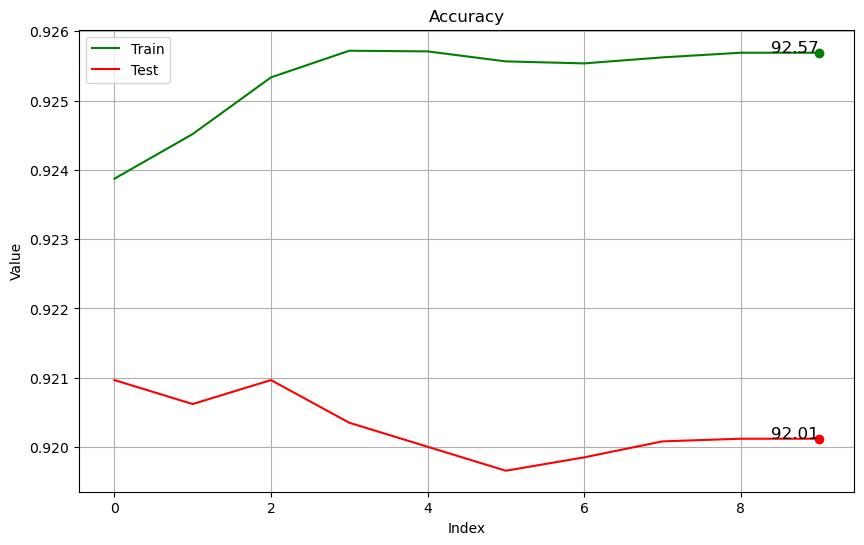

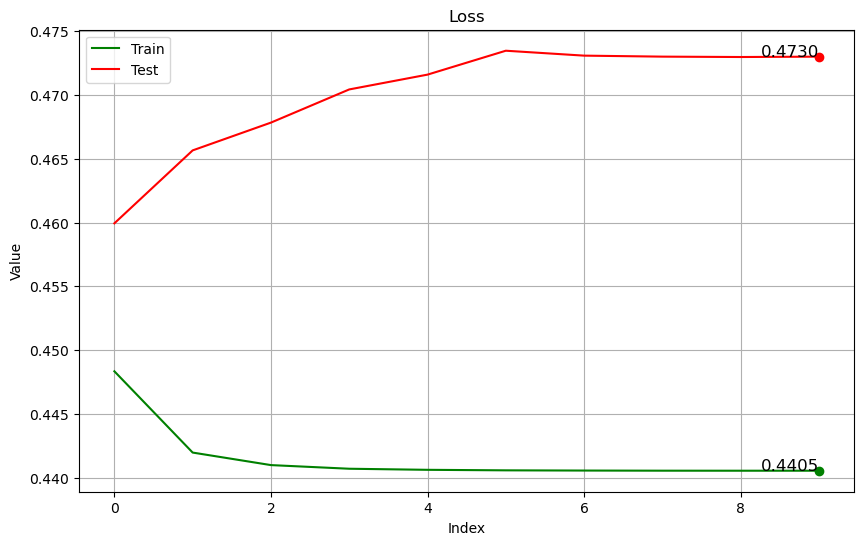

In [13]:
best_params, results, model = grid_search(param_grid)
plot_evolution(results['train_acc'], results['test_acc'], results['train_loss'], results['test_loss'])

O otimizador LBFGS teve o melhor desempenho dentre todos, independente da quantidade de steps. A desvantagem é que ele leva muito mais tempo que os outros otimizadores, mas escolhemos utilizá-lo, para tentar obter melhores métricas.

### Variando a complexidade do modelo

Aqui iremos variar os hiperparâmetros "grid", "k", tudo isso também testando diferentes valores de "steps".

In [16]:
param_grid = {
    'width': [[X_train.shape[1], 2]],
    'grid': [2, 3, 4],
    'k': [2, 3, 4],
    'steps': [10, 20, 30, 40],
    'opt': ['LBFGS']
}

obs: esqueci de mudar o nome das variáveis de results para results_2, então os gráficos abaixo na verdade são do treinamento anterior.

train loss: 4.41e-01 | test loss: 4.73e-01 | reg: 2.19e+01 : 100%|██| 10/10 [01:33<00:00,  9.33s/it]


Width: [25, 2], Grid: 2, K: 2, Steps: 10, Optimizer: LBFGS Train Acc: 0.9257, Test Acc: 0.9201


train loss: 4.41e-01 | test loss: 4.74e-01 | reg: 2.19e+01 : 100%|██| 20/20 [02:43<00:00,  8.20s/it]


Width: [25, 2], Grid: 2, K: 2, Steps: 20, Optimizer: LBFGS Train Acc: 0.9257, Test Acc: 0.9199


train loss: 4.41e-01 | test loss: 4.75e-01 | reg: 2.19e+01 : 100%|██| 30/30 [03:24<00:00,  6.82s/it]


Width: [25, 2], Grid: 2, K: 2, Steps: 30, Optimizer: LBFGS Train Acc: 0.9258, Test Acc: 0.9199


train loss: 4.41e-01 | test loss: 4.75e-01 | reg: 2.19e+01 : 100%|██| 40/40 [03:54<00:00,  5.86s/it]


Width: [25, 2], Grid: 2, K: 2, Steps: 40, Optimizer: LBFGS Train Acc: 0.9258, Test Acc: 0.9197


train loss: 4.29e-01 | test loss: 4.40e-01 | reg: 2.34e+01 : 100%|██| 10/10 [02:04<00:00, 12.47s/it]


Width: [25, 2], Grid: 2, K: 3, Steps: 10, Optimizer: LBFGS Train Acc: 0.9321, Test Acc: 0.9290


train loss: 4.28e-01 | test loss: 4.55e-01 | reg: 2.37e+01 : 100%|██| 20/20 [04:08<00:00, 12.45s/it]


Width: [25, 2], Grid: 2, K: 3, Steps: 20, Optimizer: LBFGS Train Acc: 0.9328, Test Acc: 0.9269


train loss: 4.28e-01 | test loss: 4.69e-01 | reg: 2.45e+01 : 100%|██| 30/30 [06:12<00:00, 12.43s/it]


Width: [25, 2], Grid: 2, K: 3, Steps: 30, Optimizer: LBFGS Train Acc: 0.9322, Test Acc: 0.9247


train loss: 4.27e-01 | test loss: 4.92e-01 | reg: 2.53e+01 : 100%|██| 40/40 [08:16<00:00, 12.42s/it]


Width: [25, 2], Grid: 2, K: 3, Steps: 40, Optimizer: LBFGS Train Acc: 0.9333, Test Acc: 0.9217


train loss: 4.30e-01 | test loss: 4.81e-01 | reg: 2.43e+01 : 100%|██| 10/10 [02:32<00:00, 15.22s/it]


Width: [25, 2], Grid: 2, K: 4, Steps: 10, Optimizer: LBFGS Train Acc: 0.9314, Test Acc: 0.9230


train loss: 4.48e-01 | test loss: 5.51e-01 | reg: 2.58e+01 : 100%|██| 20/20 [05:06<00:00, 15.34s/it]


Width: [25, 2], Grid: 2, K: 4, Steps: 20, Optimizer: LBFGS Train Acc: 0.9219, Test Acc: 0.9089


train loss: 4.42e-01 | test loss: 4.69e-01 | reg: 2.49e+01 : 100%|██| 30/30 [07:44<00:00, 15.47s/it]


Width: [25, 2], Grid: 2, K: 4, Steps: 30, Optimizer: LBFGS Train Acc: 0.9242, Test Acc: 0.9202


train loss: 4.45e-01 | test loss: 4.65e-01 | reg: 2.33e+01 : 100%|██| 40/40 [10:18<00:00, 15.45s/it]


Width: [25, 2], Grid: 2, K: 4, Steps: 40, Optimizer: LBFGS Train Acc: 0.9231, Test Acc: 0.9202


train loss: 4.26e-01 | test loss: 4.42e-01 | reg: 2.30e+01 : 100%|██| 10/10 [01:43<00:00, 10.32s/it]


Width: [25, 2], Grid: 3, K: 2, Steps: 10, Optimizer: LBFGS Train Acc: 0.9332, Test Acc: 0.9301


train loss: 4.25e-01 | test loss: 4.35e-01 | reg: 2.35e+01 : 100%|██| 20/20 [03:29<00:00, 10.46s/it]


Width: [25, 2], Grid: 3, K: 2, Steps: 20, Optimizer: LBFGS Train Acc: 0.9336, Test Acc: 0.9314


train loss: 4.25e-01 | test loss: 4.39e-01 | reg: 2.39e+01 : 100%|██| 30/30 [05:16<00:00, 10.53s/it]


Width: [25, 2], Grid: 3, K: 2, Steps: 30, Optimizer: LBFGS Train Acc: 0.9335, Test Acc: 0.9304


train loss: 4.25e-01 | test loss: 4.35e-01 | reg: 2.47e+01 : 100%|██| 40/40 [07:04<00:00, 10.62s/it]


Width: [25, 2], Grid: 3, K: 2, Steps: 40, Optimizer: LBFGS Train Acc: 0.9336, Test Acc: 0.9310


train loss: 4.22e-01 | test loss: 4.34e-01 | reg: 2.28e+01 : 100%|██| 10/10 [02:08<00:00, 12.87s/it]


Width: [25, 2], Grid: 3, K: 3, Steps: 10, Optimizer: LBFGS Train Acc: 0.9342, Test Acc: 0.9318


train loss: 4.22e-01 | test loss: 4.68e-01 | reg: 2.33e+01 : 100%|██| 20/20 [03:39<00:00, 10.98s/it]


Width: [25, 2], Grid: 3, K: 3, Steps: 20, Optimizer: LBFGS Train Acc: 0.9342, Test Acc: 0.9241


train loss: 4.22e-01 | test loss: 5.11e-01 | reg: 2.34e+01 : 100%|██| 30/30 [04:07<00:00,  8.24s/it]


Width: [25, 2], Grid: 3, K: 3, Steps: 30, Optimizer: LBFGS Train Acc: 0.9342, Test Acc: 0.9161


train loss: 4.22e-01 | test loss: 5.41e-01 | reg: 2.35e+01 : 100%|██| 40/40 [05:29<00:00,  8.23s/it]


Width: [25, 2], Grid: 3, K: 3, Steps: 40, Optimizer: LBFGS Train Acc: 0.9341, Test Acc: 0.9112


train loss: 4.26e-01 | test loss: 4.36e-01 | reg: 2.27e+01 : 100%|██| 10/10 [01:39<00:00,  9.98s/it]


Width: [25, 2], Grid: 3, K: 4, Steps: 10, Optimizer: LBFGS Train Acc: 0.9334, Test Acc: 0.9307


train loss: 4.24e-01 | test loss: 4.26e-01 | reg: 2.25e+01 : 100%|██| 20/20 [03:22<00:00, 10.12s/it]


Width: [25, 2], Grid: 3, K: 4, Steps: 20, Optimizer: LBFGS Train Acc: 0.9337, Test Acc: 0.9331


train loss: 4.23e-01 | test loss: 4.47e-01 | reg: 2.30e+01 : 100%|██| 30/30 [05:05<00:00, 10.18s/it]


Width: [25, 2], Grid: 3, K: 4, Steps: 30, Optimizer: LBFGS Train Acc: 0.9338, Test Acc: 0.9285


train loss: 4.24e-01 | test loss: 4.37e-01 | reg: 2.30e+01 : 100%|██| 40/40 [06:49<00:00, 10.23s/it]


Width: [25, 2], Grid: 3, K: 4, Steps: 40, Optimizer: LBFGS Train Acc: 0.9340, Test Acc: 0.9306


train loss: 4.21e-01 | test loss: 4.23e-01 | reg: 2.30e+01 : 100%|██| 10/10 [01:09<00:00,  6.93s/it]


Width: [25, 2], Grid: 4, K: 2, Steps: 10, Optimizer: LBFGS Train Acc: 0.9343, Test Acc: 0.9331


train loss: 4.22e-01 | test loss: 4.25e-01 | reg: 2.32e+01 : 100%|██| 20/20 [02:22<00:00,  7.11s/it]


Width: [25, 2], Grid: 4, K: 2, Steps: 20, Optimizer: LBFGS Train Acc: 0.9342, Test Acc: 0.9330


train loss: 4.21e-01 | test loss: 4.24e-01 | reg: 2.34e+01 : 100%|██| 30/30 [03:35<00:00,  7.18s/it]


Width: [25, 2], Grid: 4, K: 2, Steps: 30, Optimizer: LBFGS Train Acc: 0.9341, Test Acc: 0.9332


train loss: 4.21e-01 | test loss: 4.25e-01 | reg: 2.34e+01 : 100%|██| 40/40 [04:50<00:00,  7.27s/it]


Width: [25, 2], Grid: 4, K: 2, Steps: 40, Optimizer: LBFGS Train Acc: 0.9342, Test Acc: 0.9332


train loss: 4.22e-01 | test loss: 4.33e-01 | reg: 2.30e+01 : 100%|██| 10/10 [01:26<00:00,  8.67s/it]


Width: [25, 2], Grid: 4, K: 3, Steps: 10, Optimizer: LBFGS Train Acc: 0.9344, Test Acc: 0.9322


train loss: 4.21e-01 | test loss: 4.32e-01 | reg: 2.30e+01 : 100%|██| 20/20 [03:02<00:00,  9.12s/it]


Width: [25, 2], Grid: 4, K: 3, Steps: 20, Optimizer: LBFGS Train Acc: 0.9346, Test Acc: 0.9321


train loss: 4.21e-01 | test loss: 4.24e-01 | reg: 2.30e+01 : 100%|██| 30/30 [04:40<00:00,  9.34s/it]


Width: [25, 2], Grid: 4, K: 3, Steps: 30, Optimizer: LBFGS Train Acc: 0.9344, Test Acc: 0.9337


train loss: 4.21e-01 | test loss: 4.25e-01 | reg: 2.29e+01 : 100%|██| 40/40 [05:51<00:00,  8.79s/it]


Width: [25, 2], Grid: 4, K: 3, Steps: 40, Optimizer: LBFGS Train Acc: 0.9345, Test Acc: 0.9336


train loss: 4.21e-01 | test loss: 4.41e-01 | reg: 2.29e+01 : 100%|██| 10/10 [01:45<00:00, 10.54s/it]


Width: [25, 2], Grid: 4, K: 4, Steps: 10, Optimizer: LBFGS Train Acc: 0.9342, Test Acc: 0.9295


train loss: 4.21e-01 | test loss: 4.55e-01 | reg: 2.26e+01 : 100%|██| 20/20 [03:34<00:00, 10.74s/it]


Width: [25, 2], Grid: 4, K: 4, Steps: 20, Optimizer: LBFGS Train Acc: 0.9342, Test Acc: 0.9268


train loss: 4.21e-01 | test loss: 4.68e-01 | reg: 2.26e+01 : 100%|██| 30/30 [05:25<00:00, 10.84s/it]


Width: [25, 2], Grid: 4, K: 4, Steps: 30, Optimizer: LBFGS Train Acc: 0.9341, Test Acc: 0.9248


train loss: 4.21e-01 | test loss: 4.69e-01 | reg: 2.26e+01 : 100%|██| 40/40 [07:09<00:00, 10.74s/it]

Width: [25, 2], Grid: 4, K: 4, Steps: 40, Optimizer: LBFGS Train Acc: 0.9342, Test Acc: 0.9242


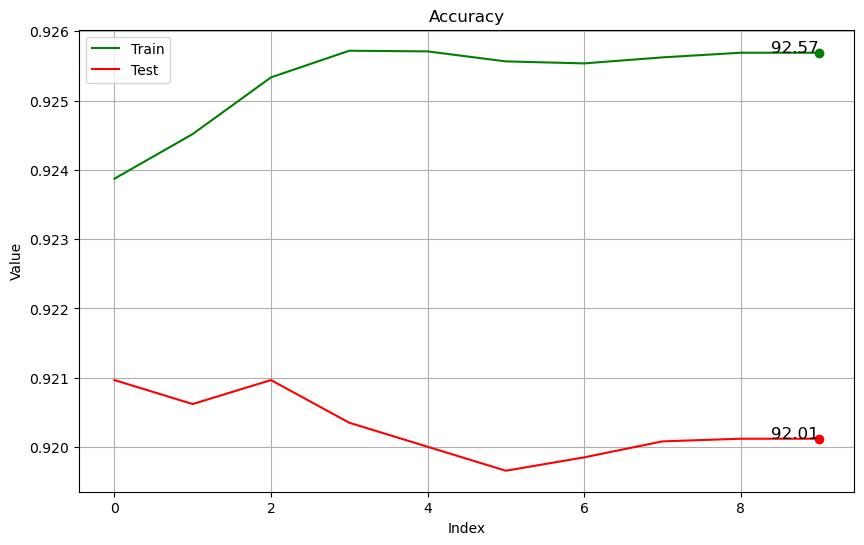

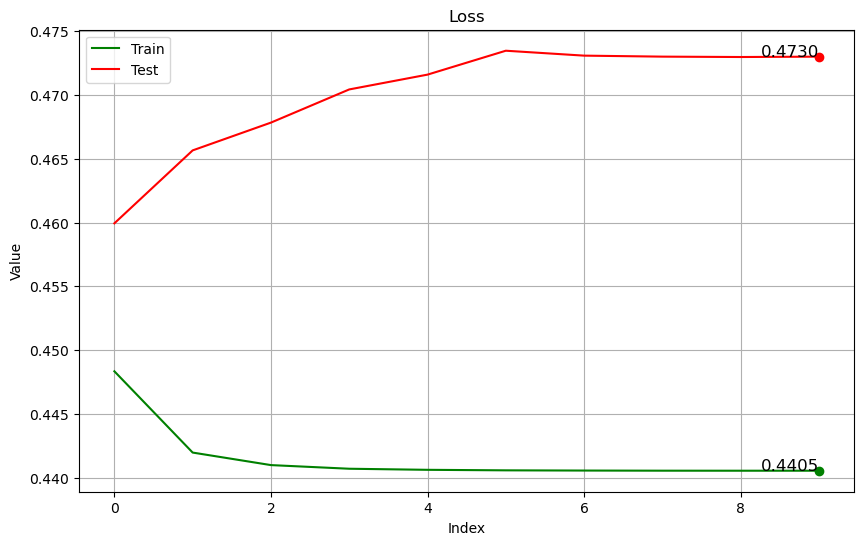

In [17]:
best_params_2, results_2, model_2 = grid_search(param_grid)
plot_evolution(results['train_acc'], results['test_acc'], results['train_loss'], results['test_loss'])

esses aqui são os gráficos do treinamento realizado:

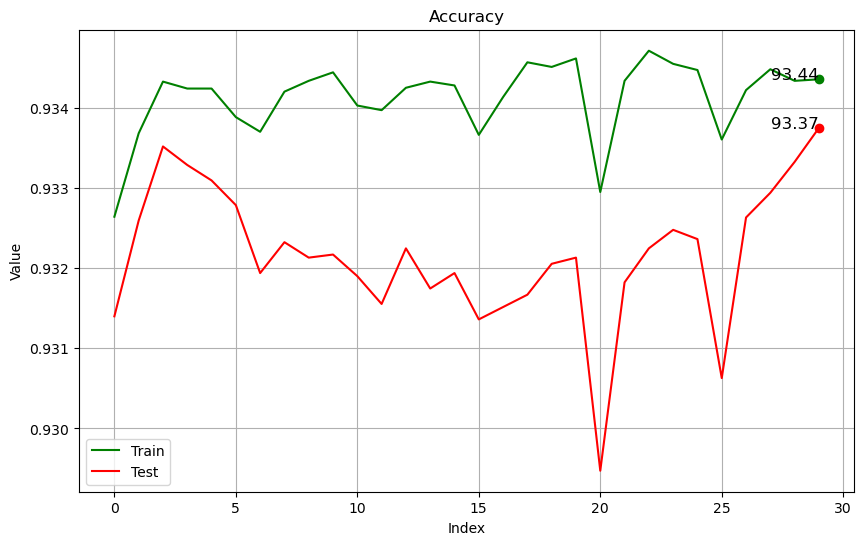

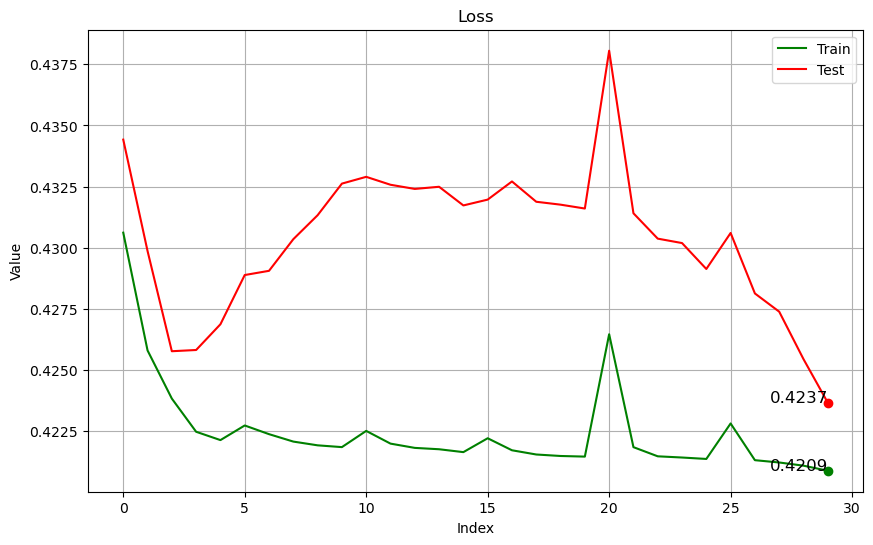

In [18]:
plot_evolution(results_2['train_acc'], results_2['test_acc'], results_2['train_loss'], results_2['test_loss'])

In [19]:
best_params_2

{'width': [25, 2], 'grid': 4, 'k': 3, 'steps': 30, 'opt': 'LBFGS'}

O melhor modelo foi com grid = 4 e k = 3, atingindo uma acurácia de 93.37% no conjunto de teste. 
- Melhores acurácias com 30 steps
  
Podemos tentar aumentar ainda mais a complexidade do modelo:

In [20]:
param_grid = {
    'width': [[X_train.shape[1], 2]],
    'grid': [6, 8, 10],
    'k': [6, 8, 10],
    'steps': [30],
    'opt': ['LBFGS']
}

train loss: 4.21e-01 | test loss: 4.24e-01 | reg: 2.35e+01 : 100%|██| 30/30 [10:13<00:00, 20.47s/it]


Width: [25, 2], Grid: 6, K: 6, Steps: 30, Optimizer: LBFGS Train Acc: 0.9345, Test Acc: 0.9338


train loss: 4.21e-01 | test loss: 4.32e-01 | reg: 2.27e+01 : 100%|██| 30/30 [13:17<00:00, 26.58s/it]


Width: [25, 2], Grid: 6, K: 8, Steps: 30, Optimizer: LBFGS Train Acc: 0.9344, Test Acc: 0.9323


train loss: 4.21e-01 | test loss: 4.58e-01 | reg: 2.28e+01 : 100%|██| 30/30 [17:29<00:00, 34.99s/it]


Width: [25, 2], Grid: 6, K: 10, Steps: 30, Optimizer: LBFGS Train Acc: 0.9344, Test Acc: 0.9266


train loss: 4.21e-01 | test loss: 4.24e-01 | reg: 2.32e+01 : 100%|██| 30/30 [10:38<00:00, 21.29s/it]


Width: [25, 2], Grid: 8, K: 6, Steps: 30, Optimizer: LBFGS Train Acc: 0.9346, Test Acc: 0.9337


train loss: 4.21e-01 | test loss: 4.23e-01 | reg: 2.25e+01 : 100%|██| 30/30 [14:06<00:00, 28.23s/it]


Width: [25, 2], Grid: 8, K: 8, Steps: 30, Optimizer: LBFGS Train Acc: 0.9343, Test Acc: 0.9344


train loss: 4.21e-01 | test loss: 4.31e-01 | reg: 2.29e+01 : 100%|██| 30/30 [18:56<00:00, 37.90s/it]


Width: [25, 2], Grid: 8, K: 10, Steps: 30, Optimizer: LBFGS Train Acc: 0.9343, Test Acc: 0.9321


train loss: 4.21e-01 | test loss: 4.41e-01 | reg: 2.29e+01 : 100%|██| 30/30 [11:04<00:00, 22.16s/it]


Width: [25, 2], Grid: 10, K: 6, Steps: 30, Optimizer: LBFGS Train Acc: 0.9345, Test Acc: 0.9306


train loss: 4.20e-01 | test loss: 4.25e-01 | reg: 2.31e+01 : 100%|██| 30/30 [15:29<00:00, 30.98s/it]


Width: [25, 2], Grid: 10, K: 8, Steps: 30, Optimizer: LBFGS Train Acc: 0.9346, Test Acc: 0.9337


train loss: 4.21e-01 | test loss: 4.38e-01 | reg: 2.26e+01 : 100%|██| 30/30 [24:42<00:00, 49.41s/it]

Width: [25, 2], Grid: 10, K: 10, Steps: 30, Optimizer: LBFGS Train Acc: 0.9344, Test Acc: 0.9316


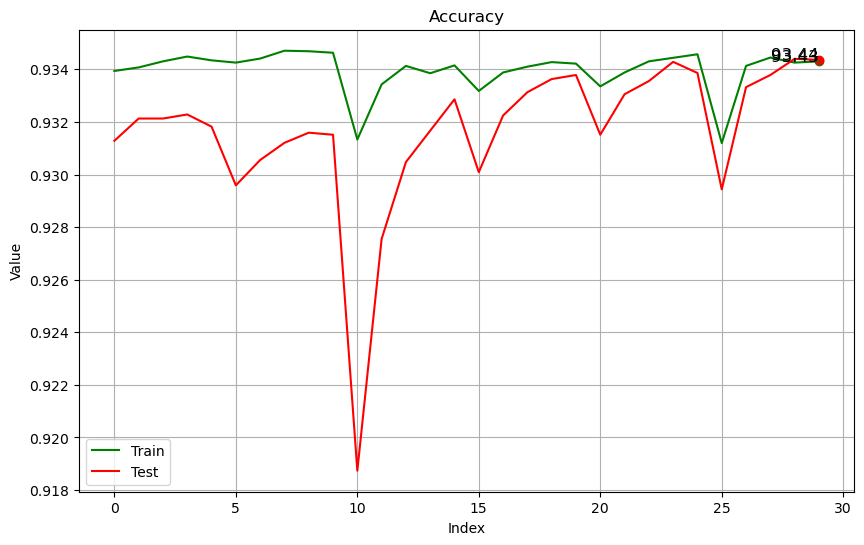

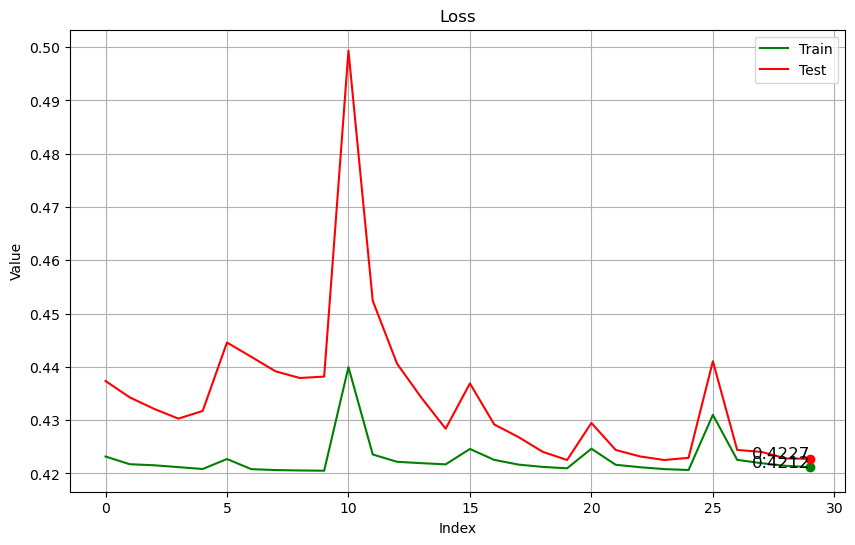

In [21]:
best_params_3, results_3, model_3 = grid_search(param_grid)
plot_evolution(results_3['train_acc'], results_3['test_acc'], results_3['train_loss'], results_3['test_loss'])

In [22]:
best_params_3

{'width': [25, 2], 'grid': 8, 'k': 8, 'steps': 30, 'opt': 'LBFGS'}

Conseguimos uma pequena melhoria, utilizando valores maiores de grid e k (ambos igual a 8), uma acurácia de 93.44%.

### Testando diferentes width

O último hiperparâmetro que falta testarmos é o "width", todos os modelos anteriores utilizou apenas o padrão [25, 2], sendo 25 a quantidade de features da entrada e 2 a quantidade de classes de saída.

In [29]:
param_grid = {
    'width': [[X_train.shape[1], 8, 2], [X_train.shape[1], 16, 2], [X_train.shape[1], 32, 2]],
    'grid': [8],
    'k': [8],
    'steps': [30],
    'opt': ['LBFGS']
}

description:   0%|                                                           | 0/30 [00:00<?, ?it/s]

train loss: 2.95e-01 | test loss: 3.98e-01 | reg: 8.30e+01 : 100%|██| 30/30 [48:04<00:00, 96.16s/it]


Width: [[25, 0], [8, 0], [2, 0]], Grid: 8, K: 8, Steps: 30, Optimizer: LBFGS Train Acc: 0.9633, Test Acc: 0.9449


train loss: 2.77e-01 | test loss: 3.61e-01 | reg: 1.56e+02 : 100%|█| 30/30 [1:32:54<00:00, 185.82s/i


Width: [[25, 0], [16, 0], [2, 0]], Grid: 8, K: 8, Steps: 30, Optimizer: LBFGS Train Acc: 0.9665, Test Acc: 0.9514


train loss: 2.59e-01 | test loss: 4.79e-01 | reg: 2.25e+02 : 100%|█| 30/30 [3:00:53<00:00, 361.77s/i


Width: [[25, 0], [32, 0], [2, 0]], Grid: 8, K: 8, Steps: 30, Optimizer: LBFGS Train Acc: 0.9708, Test Acc: 0.9503


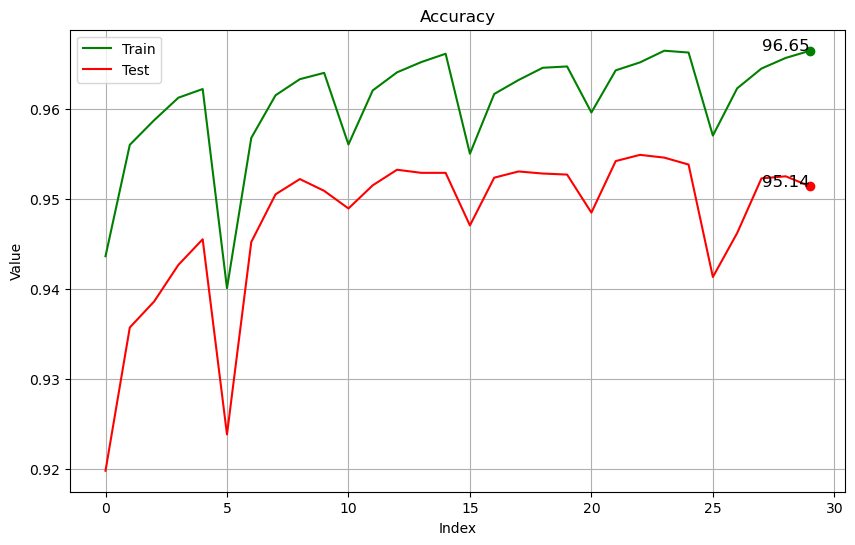

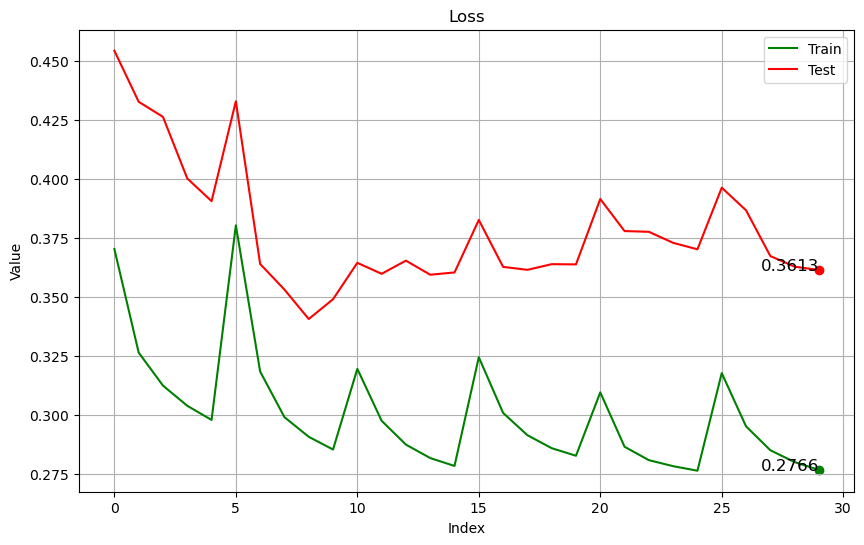

In [30]:
best_params_4, results_4, model_4 = grid_search(param_grid)
plot_evolution(results_4['train_acc'], results_4['test_acc'], results_4['train_loss'], results_4['test_loss'])

Fazendo testes com mais uma camada, obtivemos melhores resultados com width = [25, 16, 2], com acurácia de 95.14%. Podemos tentar adicionar mais uma camada:

In [31]:
param_grid = {
    'width': [[X_train.shape[1], 16, 16, 2]],
    'grid': [8],
    'k': [8],
    'steps': [30],
    'opt': ['LBFGS']
}

train loss: 2.78e-01 | test loss: 3.48e-01 | reg: 1.61e+02 : 100%|█| 30/30 [3:03:36<00:00, 367.22s/i


Width: [[25, 0], [16, 0], [16, 0], [2, 0]], Grid: 8, K: 8, Steps: 30, Optimizer: LBFGS Train Acc: 0.9660, Test Acc: 0.9558


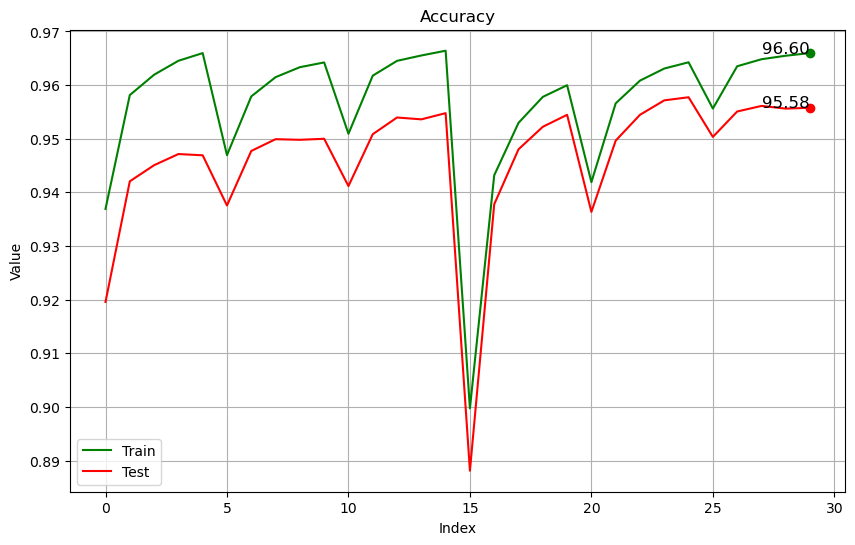

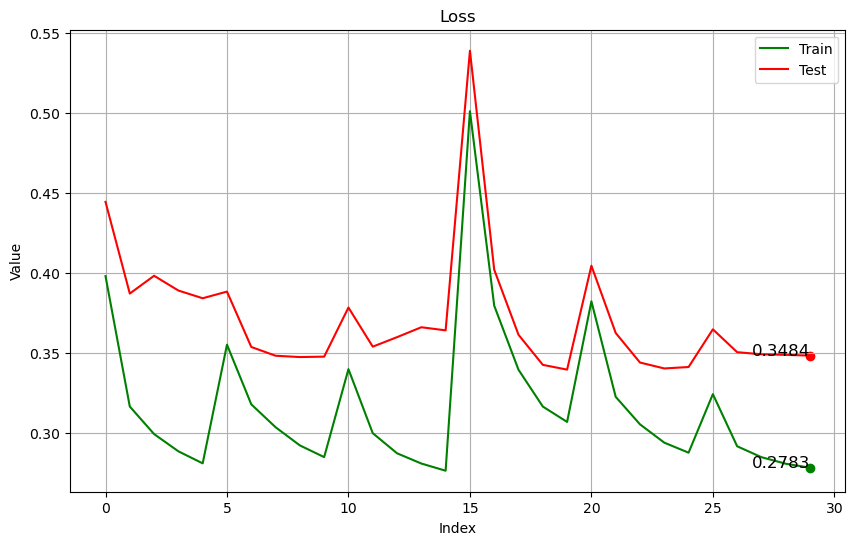

In [32]:
best_params_5, results_5, model_5 = grid_search(param_grid)
plot_evolution(results_5['train_acc'], results_5['test_acc'], results_5['train_loss'], results_5['test_loss'])

In [33]:
best_params_5

{'width': [[25, 0], [16, 0], [16, 0], [2, 0]],
 'grid': 8,
 'k': 8,
 'steps': 30,
 'opt': 'LBFGS'}

Com mais uma camada, aumentamos bastante a acurácia, subindo para 95.58%. Talvez adicionar mais camadas poderia causar uma melhoria ainda maior, mas o tempo para treinar já estava sendo muito longo com essa complexidade, então decidimos manter esse modelo mesmo.

### Métricas

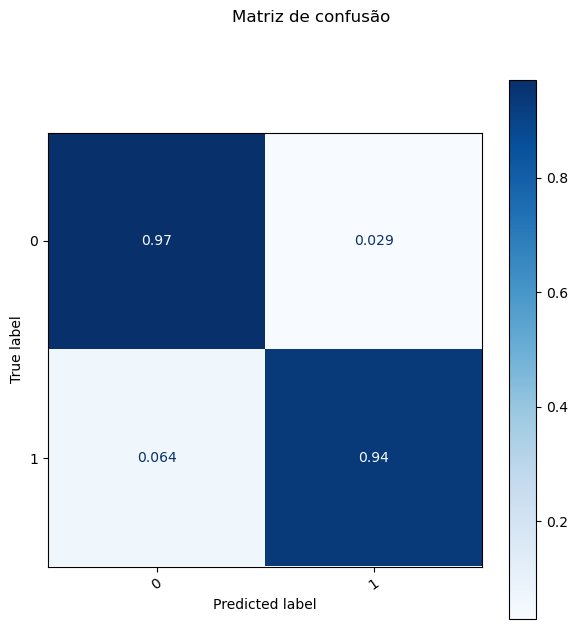

In [37]:
outs = model_5(dataset['test_input'])
preds = torch.argmax(outs, dim=1).numpy()

cm = confusion_matrix(y_test, preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
fig.suptitle("Matriz de confusão")
ax.grid(False)

# Display the normalized confusion matrix
cm_display = ConfusionMatrixDisplay(cm_normalized, display_labels=[0, 1])
cm_display.plot(ax=ax, xticks_rotation=35.0, cmap='Blues')
plt.show()

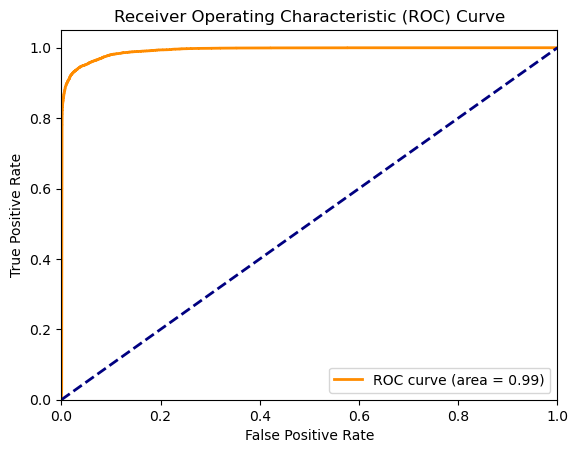

In [38]:
probs = torch.softmax(outs, dim=1).detach().numpy()
fpr, tpr, _ = roc_curve(y_test, probs[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

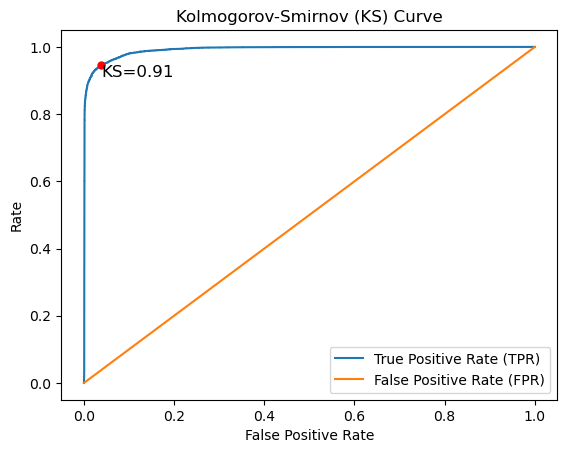

KS Statistic: 0.91


In [39]:
ks_statistic = np.max(tpr - fpr)
ks_idx = np.argmax(tpr - fpr)
plt.figure()
plt.plot(fpr, tpr, label='True Positive Rate (TPR)')
plt.plot(fpr, fpr, label='False Positive Rate (FPR)')
plt.plot([fpr[ks_idx]], [tpr[ks_idx]], marker='o', markersize=5, color="red")
plt.text(fpr[ks_idx], tpr[ks_idx], f'KS={ks_statistic:.2f}', fontsize=12, verticalalignment='top')
plt.xlabel('False Positive Rate')
plt.ylabel('Rate')
plt.title('Kolmogorov-Smirnov (KS) Curve')
plt.legend(loc='best')
plt.show()

print(f"KS Statistic: {ks_statistic:.2f}")

In [40]:
torch.save(model_5.state_dict(), 'kan_model.pth')